<a href="https://colab.research.google.com/github/lstarke/analise_de_dados_do_airbnb/blob/main/Analisando_os_Dados_do_Airbnb_(Oslo%2C_Norway).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise dos Dados do Airbnb - *Oslo, Norway*

O [Airbnb](https://www.airbnb.com.br/) já é considerado como sendo a **maior empresa hoteleira da atualidade**. Ah, o detalhe é que ele **não possui nenhum hotel**!

Conectando pessoas que querem viajar (e se hospedar) com anfitriões que querem alugar seus imóveis de maneira prática, o Airbnb fornece uma plataforma inovadora para tornar essa hospedagem alternativa.

No final de 2018, a Startup fundada 10 anos atrás, já havia **hospedado mais de 300 milhões** de pessoas ao redor de todo o mundo, desafiando as redes hoteleiras tradicionais.

Uma das iniciativas do Airbnb é disponibilizar dados do site, para algumas das principais cidades do mundo. Por meio do portal [Inside Airbnb](http://insideairbnb.com/get-the-data.html), é possível baixar uma grande quantidade de dados para desenvolver projetos e soluções de *Data Science*.

<center><img alt="Analisando Airbnb" width="20%" src="https://vidacigana.com/wp-content/uploads/2018/06/como-funciona-airbnb-1.jpg"></center>

**Neste *notebook*, iremos analisar os dados referentes à cidade Oslo, Norway, e ver quais insights podem ser extraídos a partir de dados brutos.**

<center><img alt="Oslo Mapa" width="60%" src="https://thumbs.dreamstime.com/z/pin-oslo-norway-world-map-136775868.jpg
"></center>

**Oslo**, a capital da **Noruega**, fica no litoral sul do país, na cabeceira do fiorde de Oslo. A cidade é conhecida por suas áreas verdes e seus museus. Muitos deles ficam na Península Bygdøy, como o Museu Marítimo Norueguês, nas margens da península, e o Museu do Navio Viking, com exemplares do século IX. A Holmenkollbakken é uma colina para a prática de saltos de esqui com vista panorâmica do fiorde e um museu de esqui.

## Obtenção dos Dados


In [4]:
# importar os pacotes necessarios
import pandas as pd
import numpy as np
import requests
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from matplotlib.cbook import boxplot_stats


%matplotlib inline

In [5]:
# importar o arquivo listings.csv para um DataFrame
df = pd.read_csv('listings.csv', sep=',', index_col='id')

## Análise dos Dados


**Dicionário das variáveis**

1. `id` - número de id gerado para identificar o imóvel
1. `name` - nome da propriedade anunciada
1. `host_id` - número de id do proprietário (anfitrião) da propriedade
1. `host_name` - Nome do anfitrião
1. `neighbourhood_group` - esta coluna não contém nenhum valor válido
1. `neighbourhood` - nome do bairro
1. `latitude` - coordenada da latitude da propriedade
1. `longitude` - coordenada da longitude da propriedade
1. `room_type` - informa o tipo de quarto que é oferecido
1. `price` - preço para alugar o imóvel
1. `minimum_nights` - quantidade mínima de noites para reservar
1. `number_of_reviews` - número de reviews que a propriedade possui
1. `last_review` - data do último review
1. `reviews_per_month` - quantidade de reviews por mês
1. `calculated_host_listings_count` - quantidade de imóveis do mesmo anfitrião
1. `availability_365` - número de dias de disponibilidade dentro de 365 dias
1. `number_of_reviews_ltm`- numero de avaliações dos ultimos 12 meses

Antes de iniciar qualquer análise, vamos verificar a cara do nosso *dataset*, analisando as 5 primeiras entradas.

In [6]:
# mostrar as 5 primeiras entradas
df.head()

name  ...  license
id                                                       ...         
42932               Charming apartment, Oslo Center, Ro  ...      NaN
69964                   Lovely flat in Oslo city centre  ...      NaN
71725                Central big room - ap with balcony  ...      NaN
85902  Stylish design apt, east. Close to train station  ...      NaN
92103                       Trendy Urban Downtown Oslo.  ...      NaN

[5 rows x 17 columns]

### **Q1. Quantos atributos (variáveis) e quantas entradas o nosso conjunto de dados possui? Quais os tipos das variáveis?**

In [7]:
# identificar o volume de dados do DataFrame
print(f'Variáveis (colunas):\t{df.shape[1]}\nEntradas (linhas):\t{df.shape[0]}')

Variáveis (colunas):	17
Entradas (linhas):	3384


In [8]:
# verificando o tipo das variáveis
df.dtypes

name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                           float64
dtype: object

Podemos comparar o tipo das variáveis com as cinco primeiras entradas do nosso Dataframe e verificar se faz sentido determinada variável ser daquele tipo.

Uma boa prática é alterar as variáveis que são datas para o tipo `Datetime`, vamos fazer isto com a variável `last_review`. 

In [9]:
# alterando tipo de Object para Datetime
df.last_review = pd.to_datetime(df.last_review, format='%Y-%m-%d')

### **Q2. Qual a porcentagem de valores ausentes no *dataset*?**

In [10]:
# ordenar em ordem decrescente as variáveis por seus valores ausentes
((df.isna().sum() / df.shape[0]) * 100).sort_values(ascending=False)

license                           100.000000
neighbourhood_group               100.000000
last_review                        15.425532
reviews_per_month                  15.425532
name                                0.029551
latitude                            0.000000
longitude                           0.000000
room_type                           0.000000
host_id                             0.000000
minimum_nights                      0.000000
number_of_reviews                   0.000000
neighbourhood                       0.000000
host_name                           0.000000
calculated_host_listings_count      0.000000
availability_365                    0.000000
number_of_reviews_ltm               0.000000
price                               0.000000
dtype: float64

In [11]:
# removendo as variáveis license e neighbourhood_group por não terem nenhum dado
df.drop(labels=['license', 'neighbourhood_group'], axis=1, inplace=True)

### **Q3. Qual o tipo de distribuição das variáveis?** 

Parece que as variáveis ```price``` e ```minimum_nights``` possuem alguns dados não condizentes ao seu contexto.

O histograma nos mostra que ```price``` e ```minimum_nights``` tem um valor de aluguel em torno de 80000 e quantidade mínima de diárias em torno de 500, respectivamente.

Também podemos colocar em nosso radar a variável ```calculated_host_listings_count```, uma quantidade de imóveis do mesmo anfitrião maior que 60 soa um pouco estranho.



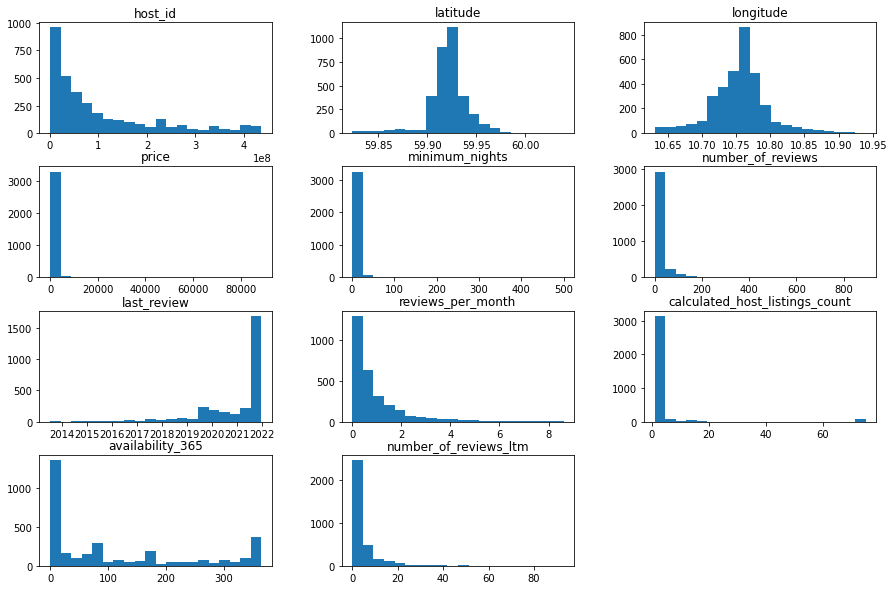

In [12]:
# plotar o histograma das variáveis numéricas
df.hist(bins=20, figsize=(15,10), grid=False);

### Inspecionando ```price``` e ```minimum_nights```


In [13]:
# verificando valores estatisticos
df[['price', 'minimum_nights', 'calculated_host_listings_count']].describe().round(1)

price  minimum_nights  calculated_host_listings_count
count   3384.0          3384.0                          3384.0
mean    1348.0             5.9                             3.3
std     2686.7            22.3                            11.0
min        0.0             1.0                             1.0
25%      650.0             2.0                             1.0
50%      920.5             2.0                             1.0
75%     1400.0             4.0                             1.0
max    88560.0           500.0                            75.0

A tabela acima comprova o que os histogramas nos mostraram e nos reveralam valores exatos.

1. ```price``` tem um valor mínimo de **0** e máximo de **88560**
2. ```minimum_nights``` tem um valor máximo de **500**
3. ```calculated_host_listings_count```tem um valor máximo de **75**



### Removendo Outliers

Para responder as próximas perguntas temos que melhorar a qualidade de nossos dados. Já vimos que algo não está muito correto nas variáveis ```price```, ```minimum_nights``` e ```calculated_host_listings_count```.

Vamos começar plotando um gráfico de boxplot que nos permite a visualização da distribuição e valores discrepantes (outliers) dos dados.

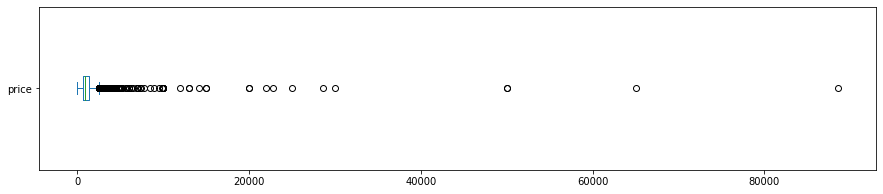

In [14]:
# imprimindo boxplot da variável price
df.price.plot(kind='box', vert=False, figsize=(15, 3));

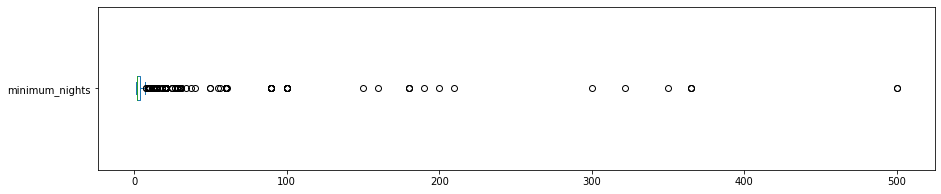

In [15]:
# imprimindo boxplot da variável minimum_nights
df.minimum_nights.plot(kind='box', vert=False, figsize=(15, 3));

Abaixo temos uma figura que detalha as áreas de um box plot, podemos ver claramente a presença de possíveis outliers em nossas variáveis.



<center><img alt="Museu do Navio Viking" width="50%" src="https://www.laboneconsultoria.com.br/wp-content/uploads/2018/07/Boxplot-04.png
"></center>



Para nos auxiliar na remoção dos outliers vamos utilizar a função ```matplotlib.cbook.boxplot_stats```

Olhando o código fonte desta função podemos vemos que esta função retorna uma lista de dicionários com dados estatísticos usados em nosso boxplot

                ========   ===================================
                Key        Value Description
                ========   ===================================
                label      tick label for the boxplot
                mean       arithmetic mean value
                med        50th percentile
                q1         first quartile (25th percentile)
                q3         third quartile (75th percentile)
                cilo       lower notch around the median
                cihi       upper notch around the median
                whislo     end of the lower whisker
                whishi     end of the upper whisker
                fliers     outliers
                ========   ===================================
Para facilitar o entendimento do retorno de cada chave desta função veja a figura abaixo:

<center><img alt="Analisando Airbnb" width="60%" src="https://i.stack.imgur.com/urPEC.jpg"></center>

Vejamos agora estes valores para as variáveis ```price``` e ```minimum_nights```.


  


In [16]:
# calculando estatísticas do boxplot
stats = boxplot_stats([df.price, df.minimum_nights])

# pegando as estatísticas de price
price_stats = stats[0]
# pegando as estatísticas de minimum_nights
minimum_nights_stats = stats[1]

# removendo possíveis outliers da variável price
df = df[df.price <= price_stats['whishi']]
df = df[df.minimum_nights <= minimum_nights_stats['whishi']]

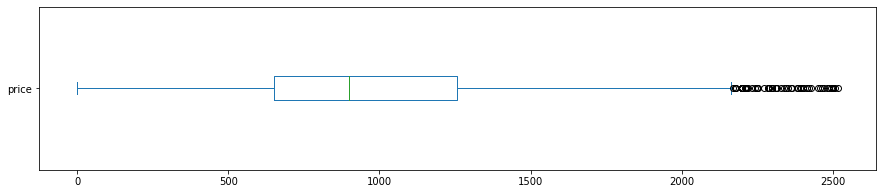

In [17]:
df.price.plot(kind='box', vert=False, figsize=(15, 3));

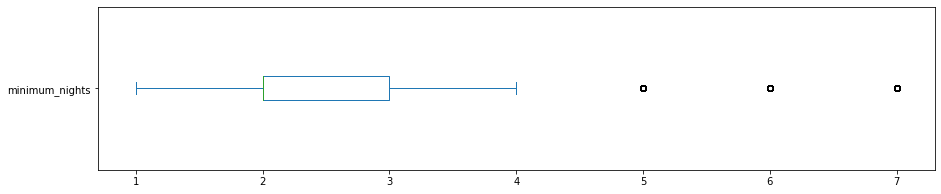

In [18]:
df.minimum_nights.plot(kind='box', vert=False, figsize=(15, 3));

Após a remoção de possiveis outliers, nosso boxplot já tem cara de boxplot.Vejamos tambem os histogramas.

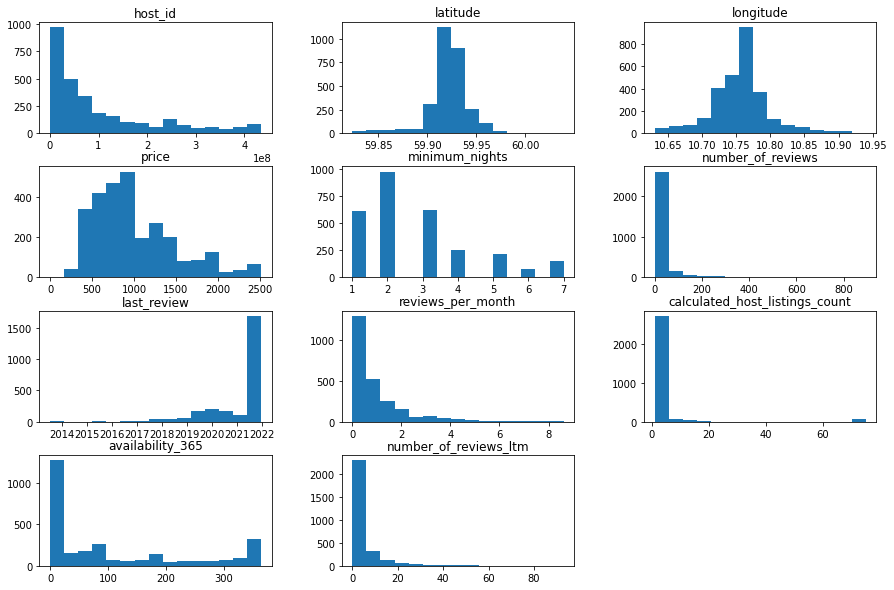

In [19]:
# plotar o histograma das variáveis numéricas
df.hist(bins=15, figsize=(15,10), grid=False);

Perceba como as variáveis ```price```e ```minimum_nights``` estão muito melhor distribuidas.

Conseguimos ver agora que ```price``` tem valores entre 0 e aproximadamente 2000 e ```minimum_nights```entre 1 e 4.

Com isso conseguimos responder as próximas perguntas com mais exatidão.

### **Q4. Qual a média dos preços de aluguel?**

In [20]:
# ver a média da coluna `price``
round(df.price.mean(), 1)

1013.5

### **Q4. Qual a correlação existente entre as variáveis**

In [21]:
# criar uma matriz de correlação
corr = df[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm']].corr()

# mostrar a matriz de correlação
display(corr.round(2))

price  ...  number_of_reviews_ltm
price                            1.00  ...                  -0.07
minimum_nights                   0.13  ...                  -0.16
number_of_reviews               -0.10  ...                   0.47
reviews_per_month               -0.12  ...                   0.64
calculated_host_listings_count  -0.08  ...                   0.16
availability_365                 0.12  ...                   0.16
number_of_reviews_ltm           -0.07  ...                   1.00

[7 rows x 7 columns]

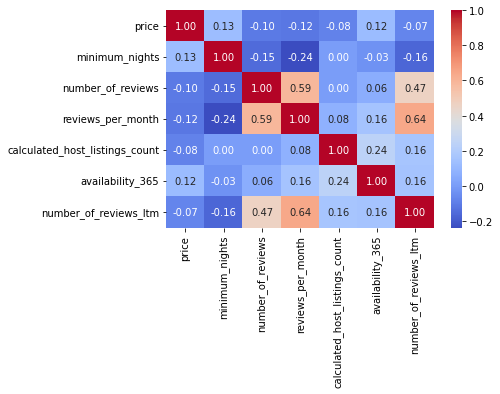

In [22]:
# plotar um heatmap a partir das correlações
ax = sns.heatmap(corr, cmap='coolwarm', linecolor='white', annot=True, fmt=".2f")

No mapa de calor acima podemos ver que as unicas variáveis que mostram alguma correlação são as variáveis relacionadas a reviews dos hóspedes.

### **Q5. Qual o tipo de imóvel mais alugado no Airbnb?**

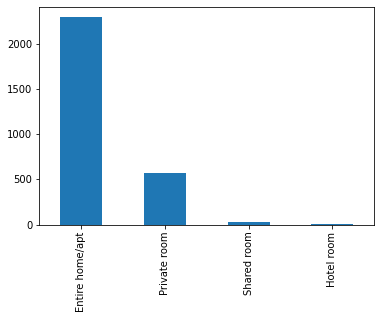

In [23]:
# mostrar a quantidade de cada tipo de imóvel disponível
df.room_type.value_counts().plot(kind='bar');

In [24]:
# mostrar a porcentagem de cada tipo de imóvel disponível
df.room_type.value_counts() / df.shape[0]

Entire home/apt    0.792185
Private room       0.197441
Shared room        0.009336
Hotel room         0.001037
Name: room_type, dtype: float64

### **Q6. Qual a localidade mais cara do dataset?**



In [25]:
# ver preços por bairros, na média
df.groupby(by='neighbourhood').price.mean().sort_values(ascending=False)

neighbourhood
Sentrum              1235.253012
Marka                1228.166667
Vestre Aker          1172.247423
Frogner              1105.958963
Nordstrand           1072.081818
Nordre Aker          1066.536082
St. Hanshaugen       1018.660714
Ullern               1017.556818
Gamle Oslo            993.081319
Grünerløkka           979.648881
Sagene                948.808511
Østensjø              940.412698
Stovner               936.555556
Bjerke                847.653846
Alna                  726.785714
Søndre Nordstrand     715.289474
Grorud                708.250000
Name: price, dtype: float64

In [26]:
# quantidade de imóveis em cada bairro
df.neighbourhood.value_counts().sort_values(ascending=False)

Grünerløkka          581
Frogner              463
Gamle Oslo           455
St. Hanshaugen       392
Sagene               282
Nordstrand           110
Vestre Aker           97
Nordre Aker           97
Ullern                88
Sentrum               83
Østensjø              63
Bjerke                52
Alna                  42
Søndre Nordstrand     38
Grorud                28
Marka                 12
Stovner                9
Name: neighbourhood, dtype: int64

De acordo com o airbnb um imóvel é considerando `highly_available` quando `availability_365` for maior que `60`.

Para o airbnb, imóveis `highly_available` provavelmente não têm o proprietário presente, podem ser ilegais ou estão deslocando moradores.

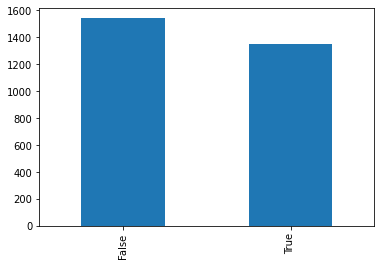

In [27]:
df['highly_available'] = df.availability_365.apply(lambda x: x > 60)
df['highly_available'].value_counts().plot(kind='bar');

In [29]:
# lista de atrações de Oslo
atracoes = ['Vigeland Sculpture Park', 
            'Akershus Fortress', 
            'Viking Ship Museum', 
            'National Museum', 
            'Munch Museum', 
            'Royal Palace', 
            'Museum of Cultural History', 
            'Fram Museum', 
            'Kon-Tiki Museum', 
            'Holmenkollen Ski Jump and Museum',
            'Oslo Cathedral',
            'City Hall (Rådhuset)',
            'Aker Brygge',
            'Museu de História Natural da Universidade de Oslo',
            'Oslo Opera House and Annual Music Festivals']

# formatando a string para passar como para a api do google maps
atracoes_fmt = [a.replace(' ','+') for a in atracoes]
atracoes_fmt = [a + ',oslo' for a in atracoes_fmt]

api_key = 'sua chave aqui'

# percorre a lista de atrações formatadas, e busca sua latitude e longitude 
for value in atracoes_fmt:

  # request para api do google maps
  response = requests.get(f'https://maps.googleapis.com/maps/api/geocode/json?address={value}&key={api_key}')
  resp_json_payload = response.json()

  # imprime o nome da atração
  print(value)
  # imprime a latitude, longitude
  print(resp_json_payload['results'][0]['geometry']['location'])

Vigeland+Sculpture+Park,oslo
{'lat': 59.927029, 'lng': 10.700865}
Akershus+Fortress,oslo
{'lat': 59.90758599999999, 'lng': 10.737084}
Viking+Ship+Museum,oslo
{'lat': 59.90494479999999, 'lng': 10.6844075}
National+Museum,oslo
{'lat': 59.91621079999999, 'lng': 10.7376067}
Munch+Museum,oslo
{'lat': 59.9061361, 'lng': 10.7557095}
Royal+Palace,oslo
{'lat': 59.9170428, 'lng': 10.7273769}
Museum+of+Cultural+History,oslo
{'lat': 59.9167934, 'lng': 10.7355229}
Fram+Museum,oslo
{'lat': 59.90338130000001, 'lng': 10.699729}
Kon-Tiki+Museum,oslo
{'lat': 59.9035075, 'lng': 10.6979806}
Holmenkollen+Ski+Jump+and+Museum,oslo
{'lat': 59.96402759999999, 'lng': 10.667762}
Oslo+Cathedral,oslo
{'lat': 59.91267560000001, 'lng': 10.7464528}
City+Hall+(Rådhuset),oslo
{'lat': 59.9121487, 'lng': 10.7337252}
Aker+Brygge,oslo
{'lat': 59.90995840000001, 'lng': 10.7258052}
Museu+de+História+Natural+da+Universidade+de+Oslo,oslo
{'lat': 59.9199634, 'lng': 10.771055}
Oslo+Opera+House+and+Annual+Music+Festivals,oslo
{'l

In [30]:
# criando dicionário dos pontos turisticos e suas localizações
pontos_turisticos = [
                     {
                         'nome': 'Vigeland Sculpture Park',
                         'lat': 59.927029,
                         'lng': 10.700865 
                     },
                     {
                         'nome': 'Akershus Fortress', 
                         'lat': 59.90758599999999,
                         'lng': 10.7370841
                     },
                     {
                         'nome': 'Viking Ship Museum',  
                         'lat': 59.90494479999999,
                         'lng': 10.6844075 
                     },
                     {
                         'nome': 'National Museum', 
                         'lat': 59.91621079999999,
                         'lng': 10.7376067 
                     },
                     {
                         'nome': 'Munch Museum', 
                         'lat': 59.9061361, 
                         'lng': 10.755709 
                     },
                     {
                         'nome': 'Royal Palace', 
                         'lat': 59.9170428, 
                         'lng': 10.7273769 
                     },
                     {
                         'nome': 'Museum of Cultural History', 
                         'lat': 59.9167934, 
                         'lng': 10.735523
                     },
                     {
                         'nome': 'Fram Museum', 
                         'lat': 59.90338130000001,
                         'lng': 10.699729 
                     },
                     {
                         'nome': 'Kon-Tiki Museum', 
                         'lat': 59.9035075,
                         'lng': 10.6979806 
                     },
                     {
                         'nome': 'Holmenkollen Ski Jump and Museum',
                         'lat': 59.96421339999999, 
                         'lng': 10.6670723 
                     },
                     {
                         'nome': 'Oslo Cathedral',
                         'lat': 59.91267560000001, 
                         'lng': 10.7464527 
                     },
                     {
                         'nome': 'City Hall (Rådhuset)',
                         'lat': 59.9121487, 
                         'lng': 10.7337252
                     },
                     {
                         'nome': 'Aker Brygge',
                         'lat': 59.90995840000001, 
                         'lng': 10.7258053
                     },
                     {
                         'nome': 'Museu de História Natural da Universidade de Oslo',
                         'lat': 59.9199634, 
                         'lng': 10.771055
                     },
                     {
                         'nome': 'Oslo Opera House and Annual Music Festivals',
                         'lat': 59.90748850000001,
                         'lng': 10.7531275
                     }
            ]

In [31]:
# plotar os imóveis pela latitude-longitude
m = folium.Map(location=[59.911491, 10.757933], width=750, height=500, tiles='cartodbpositron')    

for index, row in df.iterrows():
  if row['room_type'] == 'Entire home/apt':
    folium.Circle(
      radius=2,
      location=[row['latitude'], row['longitude']],
      popup='Price:  ' + str(row['price']),
      color="red",
      fill=True,
      fill_color="red"
    ).add_to(m)
  elif row['room_type'] == 'Private room':
    folium.Circle(
      radius=2,
      location=[row['latitude'], row['longitude']],
      popup='Price:  ' + str(row['price']),
      color="blue",
      fill=True,
      fill_color="blue"
    ).add_to(m)
  elif row['room_type'] == 'Shared room':
    folium.Circle(
      radius=2,
      location=[row['latitude'], row['longitude']],
      popup='Price:  ' + str(row['price']),
      color="green",
      fill=True,
      fill_color="green"
    ).add_to(m)
  elif row['room_type'] == 'Hotel room':
    folium.Circle(
      radius=2,
      location=[row['latitude'], row['longitude']],
      popup='Price:  ' + str(row['price']),
      color="dark",
      fill=True,
      fill_color="dark"
    ).add_to(m)

for p in pontos_turisticos:
  folium.Circle(
      radius=250,
      location=[p['lat'], p['lng']],
      popup=(p['nome']),
      color="black",
      fill=True,
      fill_color="black"
    ).add_to(m)

display('Os círculos em preto são os principais pontos turisticos em Oslo.')

m

'Os círculos em preto são os principais pontos turisticos em Oslo.'

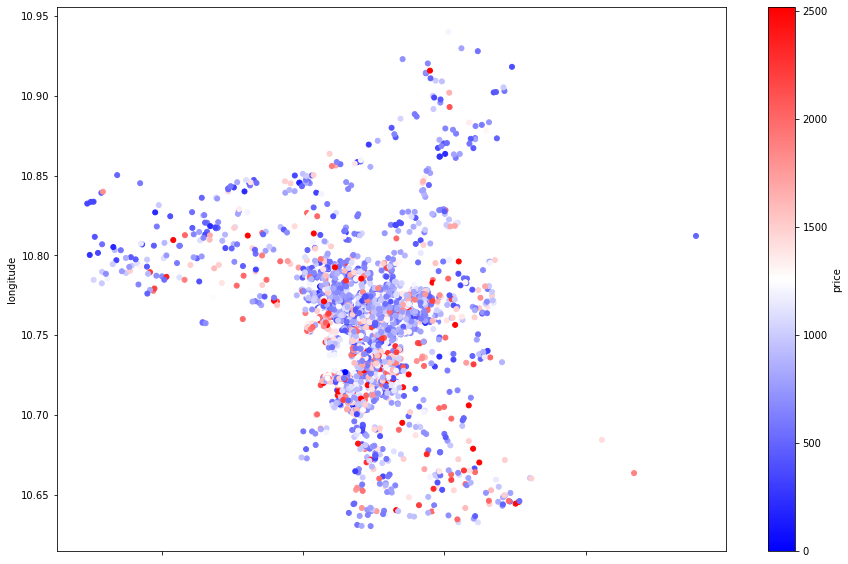

In [32]:
df.plot.scatter(x='latitude', y='longitude', c='price', cmap='bwr', s=25,  figsize=(15,10));

A partir do gráfico acima, podemos ver que é predominante imóveis que tem um valor na diária entre 500 a 1000, e que próximos aos pontos turisticos temos temos a maior concentração de opções e valores de diárias mais altas.

In [34]:
# verificando tipos de imóveis 
df.room_type.unique().tolist()

['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']

'O gráfico abaixo mostra que Oslo tem pouquissimos hoteis e a maoria dos tipos de imóveis são Casas/Apartamentos (Entire home/apt) e Quartos privados (Private Room)'

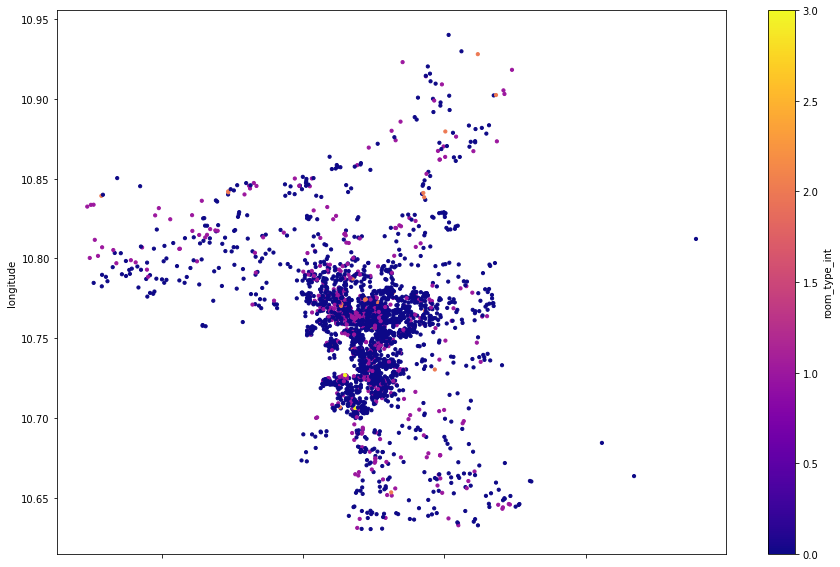

In [40]:
def aux(x):
  if x == 'Entire home/apt':
    return 0
  elif x == 'Private room':
    return 1
  elif x == 'Shared room':
    return 2
  elif x == 'Hotel room':
    return 3
  return -1

df['room_type_int'] = df.room_type.apply(aux)

colors = np.random.rand(4)
df.plot.scatter(x='latitude', y='longitude', c='room_type_int', cmap='plasma', s=10, figsize=(15,10));
display('O gráfico abaixo mostra que Oslo tem pouquissimos hoteis e a maoria dos tipos de imóveis são Casas/Apartamentos (Entire home/apt) e Quartos privados (Private Room)')

### **Q7. Qual é a média do mínimo de noites para aluguel (minimum_nights)?**

In [ ]:
# ver a média da coluna `minimum_nights``
round(df.minimum_nights.mean(), 1)

2.8

Aqui podemos interpretar que geralmente as reservas são feitas aos finais de semana. A média de noites = `2.8` provavelmente são sexta-fera, sábado e domingo.

De acordo com a documentação os dias da semana são representados por números inteiros (int), sendo eles:

0. Segunda-feira
1. Terça-feira
2. Quarta-feira
3. Quinta-feira
4. Sexta-feira
5. Sábado
6. Domingo

Vamos assumir que hóspedes deixam um comentário (review) após deixarem o imóvel.

Abaixo estão a quantidade de reviews feitos por dia da semana, podemos ver que temos uma quantidade de reviews mais altas nos domingos (6) e na segunda-feira o que nos leva a deduzir que a média minima de noites igual a 2.8 reforça que este 2.8 dias são geralmente sexta-feira, sábado e domingo.

In [53]:
# quantidade de reviews por dia da semana
df.dropna(subset=['last_review']).last_review.dt.weekday.value_counts()

6    797
0    458
4    285
5    276
3    239
1    231
2    205
Name: last_review, dtype: int64

### Q8. Existe uma diferença de preço das diárias a medida que o mesmo estiver mais longe de algum ponto turístico ?

Para esta analise, foram utilizado somente alguns pontos turísticos.

In [ ]:
# calculando a distância (km) dos imóveis para alguns pontos turisticos

def vigeland_sculpture_park(x):
  return int(geopy.distance.vincenty((x['latitude'], x['longitude']), (59.927029, 10.700865)).km)

df['vigeland_sculpture_park'] = df.apply(vigeland_sculpture_park, axis=1)

def akershus_fortress(x):
  return int(geopy.distance.vincenty((x['latitude'], x['longitude']), (59.90758599999999, 10.7370841)).km)

df['akershus_fortress'] = df.apply(akershus_fortress, axis=1)

def viking_ship_museum(x):
  return int(geopy.distance.vincenty((x['latitude'], x['longitude']), (59.90494479999999, 10.6844075)).km)

df['viking_ship_museum'] = df.apply(viking_ship_museum, axis=1)

def national_museum(x):
  return int(geopy.distance.vincenty((x['latitude'], x['longitude']), (59.91621079999999, 10.7376067)).km)

df['national_museum'] = df.apply(national_museum, axis=1)

Nos gráficos abaixo podemos ver que quanto mais distante um imóvel é de algum ponto turistico há um tendência de baixa no valor da diária.

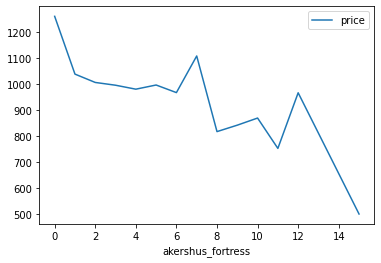

In [ ]:
df[['price', 'akershus_fortress']].groupby(['akershus_fortress']).mean().plot(kind='line');

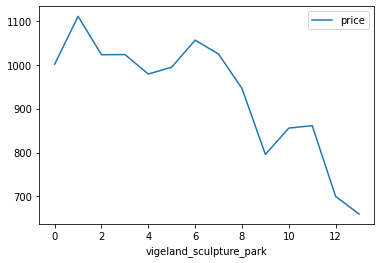

In [ ]:
df[['price', 'vigeland_sculpture_park']].groupby(['vigeland_sculpture_park']).mean().plot(kind='line');

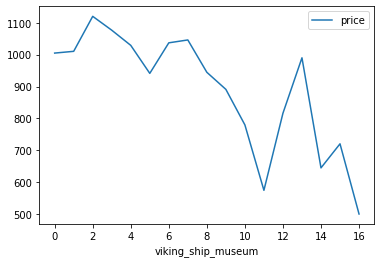

In [ ]:
df[['price', 'viking_ship_museum']].groupby(['viking_ship_museum']).mean().plot(kind='line');

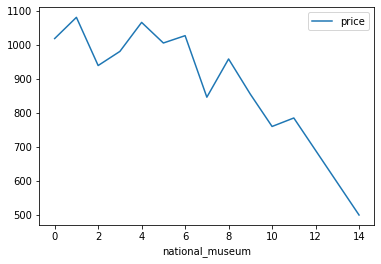

In [ ]:
df[['price', 'national_museum']].groupby(['national_museum']).mean().plot(kind='line');

## Conclusões


Este projeto tinha como objetivo fazer uma análise exploratória sobre dados disponiblizados pelo AirBnB, mostrando como é possível extrair informações que não são visíveis olhando somente para conjunto de dados prontos.

Ao iniciar a análise foram seguidos algumas etapas que ajudaram no entendimento dos dados como também geraram novas idéias de análises.

As primeiras etapas da análise foram focadas em conhecer melhor o dataset, que foram obtidos pelo portal do [inside airbnb](http://insideairbnb.com/get-the-data.html), como dimensão (quantidade de linhas e colunas), entender o significado de cada váriável (colunas), qual sua importância e seus tipos.

Em seguida seguida foram contabilizados valores ausentes no dataset, isso possibilitou a remoção das variáveis `license` e `neighbourhood_group` por serem colunas totalmente sem dados.

Com isso foram verificadas as distribuições de nossas variáveis utilizando histogramas, isto facilitou a detecção valores não condizentes com o propósito da variável.

Foi visto que a variável `price` possuia valor máximo em torno de 80000 e `minimum_nights`em torno de 500. Utilizando o boxplot nestas variáveis foi possível identificar visualmente estas discrepâncias e com  funções estatísticas elas foram removidas do conjunto de dados. 

Depois de termos dados mais limpos foi iniciada a etapa de verificação individual de alguma variáveis. Nesta etapa foi visto que `price` tem uma média 1013.5, alem disso foram verificadas a correlação das variáveis quantitativas do dataset, onde, somente as variáveis relacionadas aos `reviews` dos hóspedes mostraram algum sinal de correlação.

Utilizando os dados de latitude e longitude do dataset foi possível mostrar o mapa de Oslo com a localização de cada imóvel, este mapa mostra que o tipo de imóvel predominante em Oslo é do tipo *Entire home/apt* e que há uma maior concentração de imóveis ao redor dos pontos turisticos (lógicamente).

A quantidade mínima de noites para aluguel é de 2.8 dias, isto nos leva a pensar que muito provavelmente esta quantidade represente o final de semana. Para tentar provar isto foram utilizadas as datas do ultimo review e verificado em que dia da semana foi feito o ultimo review. Com isso foi visto que há uma quantidade maior em reviews feitos aos domingos e as segundas-feiras, reforçando a hipótese de o valor de 2.8 geralmente são de reservas feitas para finais de semana (sexta-feira, sábado e domingo).

Por fim, foram calculadas as distancias entre os imóveis e os pontos turisticos, com isso pode-se verificar que há uma tendencia de baixa no preço da diária a medida que a distância aumenta entre os dois pontos.


# Referências

1. [boxplot stats](https://github.com/matplotlib/matplotlib/blob/v3.5.1/lib/matplotlib/cbook/__init__.py#L1045-L1242)
1. [matplotlib colormaps](https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html)
1. [geopy](https://geopy.readthedocs.io/en/stable/#module-geopy.distance)

---

Vamos nos conectar no LinkedIn: [Leandro Starke](https://www.linkedin.com/in/leandrostarke/)